### Importing Required Libraries 

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import os
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import FastText
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kianathakkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kianathakkar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### We will use Word2Vec, Fastext and BERT for creating word embeddings

In [3]:
print(os.getcwd())

/Users/kianathakkar/Documents/NLP


In [4]:
# Specify the folder path where your CSV files are located
folder_path = "/Users/kianathakkar/Documents/dataset/Bigbasket/BigBasket_Data.csv"

df = pd.read_csv(folder_path)

In [5]:
df.head()

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,"This Product contains Garlic Oil that is known to help proper digestion, maintain proper cholest..."
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), refrigerator safe, dishwasher safe and can also be..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your mother, sister, in-laws, boss or your friends, this..."
3,4,Cereal Flip Lid Container/Storage Jar - Assorted Colour,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive design and made from food-grade plastic for your hygie...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best care that it must get. The soft bar consists of V...


In [6]:
df = df.drop_duplicates()

In [7]:
# Preprocessing: Combine columns into 'Description'
df['combined_text'] = df['product'] + ' ' + df['category'] + ' ' + df['sub_category'] + ' ' + df['brand']+ ' ' + df['type']
# + '' + df['description']

In [8]:
df = df.dropna()

### Preprocessing Text To Remove stop words,punctuation etc

In [9]:
def remove_special_characters(text):
    # Use regex to remove all non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    return text

def remove_stop_words_and_lemmatize(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

In [10]:
# List of column names to clean
columns_to_clean = ['combined_text','product', 'category', 'sub_category','brand','type']

# Apply the functions to each column in the DataFrame
for column in columns_to_clean:
# Apply the special character removal function
    df[column + '_v1'] = df[column].apply(remove_special_characters)
    
    # Apply the stop word removal function
    df[column + '_v1'] = df[column + '_v1'].apply(remove_stop_words_and_lemmatize)

In [11]:
df['length'] = df['combined_text_v1'].str.len()

### Visualising sentence length distribution to decide max_length for BERT

In [12]:
df['word_count'] = df['combined_text_v1'].apply(lambda x: len(x.split()))

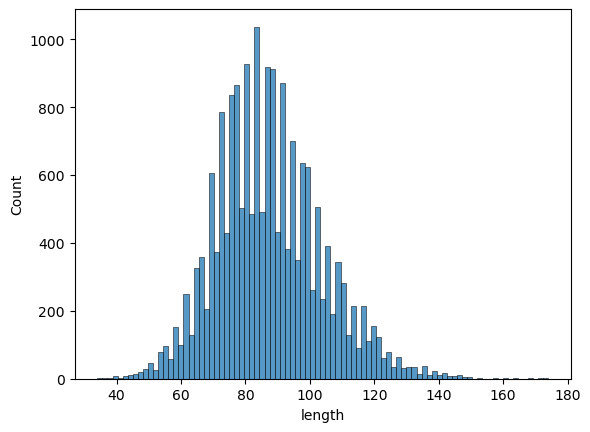

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(x=df['length'])
plt.show()

### Getting vocab size for the combined text

In [14]:
# Create an empty set to store unique words
unique_words = set()

# Tokenize the text and add unique words to the set
for text in df['combined_text_v1']:
    words = text.split()  # Split text into words
    unique_words.update(words)  # Add unique words to the set

# Calculate the vocabulary size (number of unique words)
vocab_size = len(unique_words)

print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9389


In [15]:
df.head()

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description,combined_text,combined_text_v1,product_v1,category_v1,sub_category_v1,brand_v1,type_v1,length,word_count
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,"This Product contains Garlic Oil that is known to help proper digestion, maintain proper cholest...",Garlic Oil - Vegetarian Capsule 500 mg Beauty & Hygiene Hair Care Sri Sri Ayurveda Hair Oil & S...,garlic oil vegetarian capsule 500 mg beauty hygiene hair care sri sri ayurveda hair oil serum,garlic oil vegetarian capsule 500 mg,beauty hygiene,hair care,sri sri ayurveda,hair oil serum,93,16
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), refrigerator safe, dishwasher safe and can also be...","Water Bottle - Orange Kitchen, Garden & Pets Storage & Accessories Mastercook Water & Fridge Bot...",water bottle orange kitchen garden pet storage accessory mastercook water fridge bottle,water bottle orange,kitchen garden pet,storage accessory,mastercook,water fridge bottle,87,12
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your mother, sister, in-laws, boss or your friends, this...","Brass Angle Deep - Plain, No.2 Cleaning & Household Pooja Needs Trm Lamp & Lamp Oil",brass angle deep plain no2 cleaning household pooja need trm lamp lamp oil,brass angle deep plain no2,cleaning household,pooja need,trm,lamp lamp oil,74,13
3,4,Cereal Flip Lid Container/Storage Jar - Assorted Colour,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive design and made from food-grade plastic for your hygie...,Cereal Flip Lid Container/Storage Jar - Assorted Colour Cleaning & Household Bins & Bathroom War...,cereal flip lid containerstorage jar assorted colour cleaning household bin bathroom ware nakoda...,cereal flip lid containerstorage jar assorted colour,cleaning household,bin bathroom ware,nakoda,laundry storage basket,119,16
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best care that it must get. The soft bar consists of V...,Creme Soft Soap - For Hands & Body Beauty & Hygiene Bath & Hand Wash Nivea Bathing Bars & Soaps,creme soft soap hand body beauty hygiene bath hand wash nivea bathing bar soap,creme soft soap hand body,beauty hygiene,bath hand wash,nivea,bathing bar soap,78,14


In [16]:
# Initialize an empty list for sentences
sentences = []

# List of columns you want to include
columns_to_train = ['combined_text_v1','product_v1', 'category_v1', 'sub_category_v1','brand_v1','type_v1']

# Iterate through the columns and extend the sentences list
for column in columns_to_train:
    sentences.extend([text.split() for text in df[column]])


In [18]:
# Word2Vec implementation
model_wordtovec = Word2Vec(sentences, vector_size=200, window=20, min_count=1, sg=0,alpha=0.05, epochs=100, negative=5) 

In [19]:
# Model using FastText
model_fastext = FastText(sentences, vector_size=200, window=20, min_count=1, sg=0,epochs=100)

In [20]:
def calculate_weighted_average_vector(list_of_columns, weights):
  """Calculates the weighted average of word2vec vectors.

  Args:
    words: A list of words.
    weights: A list of weights for the words.

  Returns:
    A NumPy array representing the weighted average of the word2vec vectors.
  """

  vectors = []
  for i, column in enumerate(list_of_columns):
    # If the word is a phrase, split it into individual words.
    if isinstance(column, str) and len(column.split()) > 1:
      words = column.split()
    for word in words:
      if word in model_wordtovec.wv:
        vectors.append(model_wordtovec.wv[word] * weights[i])
  if vectors:
    return np.sum(vectors, axis=0)/np.sum(weights) 
  else:
    return np.zeros(model_wordtovec.vector_size)


# Create a product vector for each row in the DataFrame for Word2Vec
df['product_vector_word2vec'] = df[['product_v1', 'category_v1', 'sub_category_v1', 'brand_v1', 'type_v1']].apply(lambda row: calculate_weighted_average_vector(row.tolist(), [0.45, 0.15, 0.1, 0.25, 0.05]), axis=1)


In [21]:
def calculate_weighted_average_vector_fasttext(list_of_columns, weights):
  """Calculates the weighted average of FastText vectors.

  Args:
    words: A list of words.
    weights: A list of weights for the words.

  Returns:
    A NumPy array representing the weighted average of the FastText vectors.
  """

  vectors = []
  for i, column in enumerate(list_of_columns):
    vectors.append(model_fastext.wv[column] * weights[i])
  return  np.sum(vectors, axis=0)/np.sum(weights) 

# Create a product vector for each row in the DataFrame for fasttext
df['product_vector_fastext'] = df[['product_v1', 'category_v1', 'sub_category_v1', 'brand_v1', 'type_v1']].apply(lambda row: calculate_weighted_average_vector_fasttext(row.tolist(), [0.45, 0.15, 0.1, 0.25, 0.05]), axis=1)

In [22]:
def calculate_cosine_similarity(vector1, vector2):
    
  dot_product = np.dot(vector1, vector2)
  magnitude = np.linalg.norm(vector1) * np.linalg.norm(vector2)
  cosine_similarity = dot_product / magnitude
  return cosine_similarity

In [33]:
user_query = 'face wash active'
user_query = remove_special_characters(user_query)
user_query = remove_stop_words_and_lemmatize(user_query)
# Get the query vector
query_vector_word2vec = model_wordtovec.wv[user_query.split()].mean(axis=0)

In [34]:
def get_similarity_word2vec(query):
  # Create a list to store the cosine similarities
  cosine_similarities_word2vec = []

  # Loop through the product vectors
  for product_vector in df['product_vector_word2vec']:

    # Calculate the cosine similarity between the query vector and the product vector
    cosine_similarity = calculate_cosine_similarity(query_vector_word2vec, product_vector)

    # Add the cosine similarity to the list
    cosine_similarities_word2vec.append(cosine_similarity)

  # Get the product indices with the highest cosine similarities
  most_similar_product_indices_wvc = np.argsort(cosine_similarities_word2vec)[-10:]

  # Get the product rows with the highest cosine similarities
  most_similar_product_rows_word2vec = df.iloc[most_similar_product_indices_wvc]

  # Print the most similar product rows
  return print(most_similar_product_rows_word2vec[['product','category','brand','market_price']])

In [35]:
def get_similarity_fastext(query):

  query_vector_fastext = model_fastext.wv[user_query]

  # Create a list to store the cosine similarities
  cosine_similarities_fastext = []

  # Loop through the product vectors
  for product_vector in df['product_vector_fastext']:

    # Calculate the cosine similarity between the query vector and the product vector
    cosine_similarity = calculate_cosine_similarity(query_vector_fastext, product_vector)

    # Add the cosine similarity to the list
    cosine_similarities_fastext.append(cosine_similarity)

  # Get the product indices with the highest cosine similarities
  most_similar_product_indices_ftxt = np.argsort(cosine_similarities_fastext)[-10:]

  # Get the product rows with the highest cosine similarities
  most_similar_product_rows_ftxt = df.iloc[most_similar_product_indices_ftxt]

  # Print the most similar product rows
  return print(most_similar_product_rows_ftxt[['product','category','brand','market_price']])

In [36]:
get_similarity_fastext(user_query)

                                                                              product  \
14946                                                            Acne Clear Face Wash   
21006                                                         Active Clean Shower Gel   
9605   Active Clean Body Wash With Active Charcoal - Shower Gel For Body, Face & Hair   
1240                                                           Active Sport Face Wash   
3125                                                                  Cool Active Deo   
5448                                                                        Face Wash   
23926                                                                       Face Wash   
22579                                                         Active Clean Shower Gel   
3504                                                           Active Sport Face Wash   
12                                                    Face Wash - Oil Control, Active   

               categ

In [37]:
get_similarity_word2vec(user_query)

                                                                              product  \
8634                                                        Active Gel Hand Sanitizer   
12982                    Anti Ageing Face Wash With Hyluronic Acid & Active Vitamin C   
7297                                                       Active Charcoal Face Scrub   
22013                                             Bio Active Skin Lightening Face Gel   
14943  Active Clean Body Wash With Active Charcoal - Shower Gel For Body, Face & Hair   
8736                                       Skin Natutals - Pure Active Neem Face Wash   
9605   Active Clean Body Wash With Active Charcoal - Shower Gel For Body, Face & Hair   
12                                                    Face Wash - Oil Control, Active   
1240                                                           Active Sport Face Wash   
3504                                                           Active Sport Face Wash   

               categ